# Lecture 1.4: Time Series Data

This lecture, we are going to learn about pandas' [time series & date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-series-date-functionality) by exploring a Google trends [dataset](https://www.kaggle.com/GoogleNewsLab/food-searches-on-google-since-2004) of popular food search terms.

**Learning goals:**
- List the main time classes and apis in pandas
- Set a time index in a DataFrame
- Select dates and date ranges from a time index
- Pivot a stacked table
- Explore time series data with data visualization
- Shift a time series
- Calculate a rolling statistic
- Resample a time series
- Interpolate missing values

## 1. Introduction to Time Series

A Time Series is a sequence of data points indexed by _time_. In Pandas, there are **three** main classes related to time series. According to the [official documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html#overview):

>**Timestamp**: A specific date and time with timezone support  
**Timedelta**: An absolute time duration  
**Period**: A span of time defined by a point in time and its associated frequency  


### 1.1 Timestamp

🕗 The pandas [`Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html) represents a specific point in time.

In [1]:
import pandas as pd

pd.Timestamp('2012-12-21')

/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Timestamp('2012-12-21 00:00:00')

Like most other pandas classes, it wraps an efficient NumPy [dtype](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html#basic-datetimes) with useful methods and apis. For example, it exposes [time components](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components):

In [2]:
dt = pd.Timestamp('2012-12-21')
print(dt.dayofweek)
print(dt.day_name())

4
Friday


The `Timestamp` constructor parses many datetime representations, including python `datetime` and NumPy `datetime64`:

In [3]:
import datetime
import numpy as np

print(pd.Timestamp(2012, 12, 21))

print(pd.Timestamp(datetime.datetime(2012, 12, 21)))

print(pd.Timestamp(np.datetime64('2012-12-21')))


2012-12-21 00:00:00
2012-12-21 00:00:00
2012-12-21 00:00:00


However, pandas offers the convenient [`.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method, which parses almost anything you'll throw at it. So no need to use `Timestamp` constructors directly!

In [4]:
print(pd.to_datetime('21-12-2012'))
print(pd.to_datetime('2012-12-21'))
print(pd.to_datetime('21st of December 2012'))

2012-12-21 00:00:00
2012-12-21 00:00:00
2012-12-21 00:00:00


### 1.2 Timedelta

⏱ The pandas [`Timedelta`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html) represents a duration of time.

In [5]:
pd.Timedelta('42 days 666 hours')

Timedelta('69 days 18:00:00')

These durations can also be negative:

In [6]:
pd.Timedelta('-1 hr 3 min 3 s 7us')

Timedelta('-1 days +22:56:56.999993')

Just like `Timestamp`, `Timedelta` parses many data types, including python `timedelta` and NumPy `timedelta64`:

In [7]:
print(pd.Timedelta(days=42, hours=666))
print(pd.Timedelta(datetime.timedelta(days=42, hours=666)))
print(pd.Timedelta(np.timedelta64(1, 'ms')))

69 days 18:00:00
69 days 18:00:00
0 days 00:00:00.001000


`Timedelta`s are particularly useful to carry out arithmetic operations on `Timestamp`s. For example:

In [8]:
day1 = pd.Timestamp('2012-12-21')
print(f'The 21st of December 2012 was a {day1.day_name()}')

day2 = day1 + pd.Timedelta('1 day')
print(f'The day after was a {day2.day_name()}')

td = pd.Timestamp.now() - pd.Timestamp('2012-12-21')
print(f'It has been {td.days} days since the end of the world! 🙀')

The 21st of December 2012 was a Friday
The day after was a Saturday
It has been 3083 days since the end of the world! 🙀


### 1.3 Period

⏳ [`Period`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Period.html) represents fixed-frequency intervals.

For example, let's make a period with one hour frequency, starting on the 21st of December 2012:

In [9]:
pd.Period('2012-12-21', freq='h')

Period('2012-12-21 00:00', 'H')

You don't always have to specify the period. In fact, pandas will infer it based on the date format used as argument:

In [10]:
print(repr(pd.Period('2011-01-01')))
print(repr(pd.Period('2011-01')))

Period('2011-01-01', 'D')
Period('2011-01', 'M')


Periods aren't very useful on their own, but shine when used as a TimeSeries _index_. More on this in [this section](#2.-Time-Indexing).

## 2. Time Indexing

The `Timestamp`, `Timedelta`, and `Period` classes are quite fun for manipulating dates and time intervals, but this is a lecture about _time series_ , i.e sequences of time data. For this, we need to create time indices. 

There are three main types of time indices, one for each of the time classes:
- `DatetimeIndex` is a sequence of `Timestamp`
- `TimedeltaIndex` is a sequence of `Timedelta`
- `PeriodIndex` is a sequence of `Period`

(More details in the [official documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#overview))

Let's create a `DatetimeIndex`:

In [11]:
pd.DatetimeIndex(['2020-01-01', '2020-01-04', '2020-01-05', '2024-03-09']) 

DatetimeIndex(['2020-01-01', '2020-01-04', '2020-01-05', '2024-03-09'], dtype='datetime64[ns]', freq=None)

As always, pandas offers a more convenient way to construct `DatetimeIndex`. Use `pd.date_range()` to create regularly spaced sequences of `Timestamp`s.

In [12]:
pd.date_range('1969-07-20', periods=4, freq='H')

DatetimeIndex(['1969-07-20 00:00:00', '1969-07-20 01:00:00',
               '1969-07-20 02:00:00', '1969-07-20 03:00:00'],
              dtype='datetime64[ns]', freq='H')

We can also do the same with `TimedeltaIndex` and `PeriodIndex`:

In [13]:
pd.timedelta_range(0, periods=4, freq='H')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00'],
               dtype='timedelta64[ns]', freq='H')

In [14]:
pd.period_range('1969-07-20', periods=4, freq='H')

PeriodIndex(['1969-07-20 00:00', '1969-07-20 01:00', '1969-07-20 02:00',
             '1969-07-20 03:00'],
            dtype='period[H]', freq='H')

🧠 Notice that the `PeriodIndex` constructor looks exactly the same as the `DatetimeIndex` constructor... Can you explain the difference between these two types of indices?

We've created time indices... Now let's use them in a `Series`!


In [15]:
index = pd.date_range('2000-01-01', periods=60, freq='D')
ts = pd.Series(np.random.randn(len(index)), index=index)
ts.head()

2000-01-01    2.209096
2000-01-02    1.209691
2000-01-03   -0.892760
2000-01-04   -0.263146
2000-01-05    0.953360
Freq: D, dtype: float64

Notice how the series is "aware" of its index frequency, `D` (one day).

Since our time series is still a pandas `Series`, we can use all the indexing tricks learnt in lecture 1.2:

In [16]:
# selecting by index label
ts['2000-01-05']

0.9533604535200461

In [17]:
# selecting by index position
ts[4]

0.9533604535200461

In [18]:
# list slicing 3rd element through to 5th element
ts[2:5]

2000-01-03   -0.892760
2000-01-04   -0.263146
2000-01-05    0.953360
Freq: D, dtype: float64

In [19]:
# list slicing elements in steps of 4
ts[::4]

2000-01-01    2.209096
2000-01-05    0.953360
2000-01-09   -0.674513
2000-01-13   -0.801993
2000-01-17   -0.120817
2000-01-21   -0.073598
2000-01-25   -1.082701
2000-01-29   -2.019416
2000-02-02   -0.780613
2000-02-06    0.684251
2000-02-10   -0.685323
2000-02-14    0.499117
2000-02-18   -0.823632
2000-02-22    0.349687
2000-02-26    0.996855
Freq: 4D, dtype: float64

 Having a time index opens up many more possibilities with data selection. For example, we can...

In [20]:
# selecting by index label with datetime object
ts[datetime.datetime(2000, 1, 5)]

0.9533604535200461

In [21]:
# selecting by index label with parsed datetime string
ts['01/05/2000']

0.9533604535200461

In [22]:
# selecting by slice of parsed datetime string
ts['3rd of January 2000':'5th of January 2000']

2000-01-03   -0.892760
2000-01-04   -0.263146
2000-01-05    0.953360
Freq: D, dtype: float64

In [23]:
# selecting by range of parsed datetime string
ts['February 2000']

2000-02-01   -0.256496
2000-02-02   -0.780613
2000-02-03    0.046753
2000-02-04    0.711641
2000-02-05    1.824882
2000-02-06    0.684251
2000-02-07   -1.516002
2000-02-08    1.199076
2000-02-09    0.860225
2000-02-10   -0.685323
2000-02-11    0.740630
2000-02-12    1.824545
2000-02-13    0.564242
2000-02-14    0.499117
2000-02-15   -0.353612
2000-02-16   -0.825033
2000-02-17    0.480888
2000-02-18   -0.823632
2000-02-19   -0.865694
2000-02-20   -1.539865
2000-02-21    0.991682
2000-02-22    0.349687
2000-02-23    0.907741
2000-02-24    0.516876
2000-02-25   -1.991457
2000-02-26    0.996855
2000-02-27    0.289773
2000-02-28   -0.296282
2000-02-29    1.180664
Freq: D, dtype: float64

And, of course, all of this magic also applies to dataframes:

In [24]:
dft = pd.DataFrame(np.random.randn(666, 2), columns=['SAD', 'PEPE'], index=pd.date_range('20121221', periods=666, freq='D'))
dft.head()

,SAD,PEPE
2012-12-21,1.115148,-0.095757
2012-12-22,0.307700,0.203979
2012-12-23,1.463932,-1.517248
2012-12-24,-2.511086,0.945868
2012-12-25,0.359524,-0.761378


<AxesSubplot:>

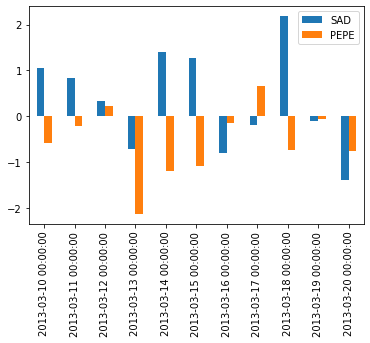

In [25]:
dft.loc['10th March 2013':'20th March 2013', :].plot.bar()

🧠 Take the time to understand what's happening in the two cells above. What's used as arguments to the `DataFrame` constructor? What is being selected with the `.loc[]` operator?


## 3. Time Series Data Exploration

Now that we've conquered the basics of `TimeSeries`, let's put our skills to practice on some real data!

The `food_searches.csv` dataset tracks the [Google trends](https://trends.google.com/trends) popularity of various foods and drinks from 2004 through 2016. Please bear in mind that most of this data is USA centric, so don't draw global conclusions on the trends just yet 🙃. 

Just like in lecture 1.2, let's start with some summary statistics to get insight into the values:

In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv('food_searches.csv')
df.head()

,id,googleTopic,week_id,value
0,frozen-yogurt,/m/020b3f,2004-01,20
1,frozen-yogurt,/m/020b3f,2004-02,16
2,frozen-yogurt,/m/020b3f,2004-03,7
3,frozen-yogurt,/m/020b3f,2004-04,7
4,frozen-yogurt,/m/020b3f,2004-05,13


In [27]:
df.describe(include='all')

,id,googleTopic,week_id,value
count,135025,135025,135025,135025.000000
unique,201,195,676,NaN
top,mai-tai,/m/0cjs7,2015-45,NaN
freq,676,2028,201,NaN
mean,NaN,NaN,NaN,29.996023
std,NaN,NaN,NaN,20.081670
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,14.000000
50%,NaN,NaN,NaN,26.000000
75%,NaN,NaN,NaN,42.000000


The `id` column holds the `string` name of the food/drink, `googleTopic` seems to be a google specific id, `week_id` is a date period, and `value` is the popularity of the search term. `value` has `min=0` and `max=100`, so we can expect a normalised value in percentage.

Notice how the `DataFrame` index is _not_ a time index:



In [28]:
df.index

RangeIndex(start=0, stop=135025, step=1)

This means we need to manually set the time index. However, `week_id` isn't a time data type...

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135025 entries, 0 to 135024
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           135025 non-null  object
 1   googleTopic  135025 non-null  object
 2   week_id      135025 non-null  object
 3   value        135025 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.1+ MB


We don't want to end up with an `object` index! Then we won't be able to do all that fancy time indexing. So first things first: let's convert `week_id` to a datetime `dtype`. Remember how pandas makes date conversion easy with `pd.to_datetime()`? Well this `week_id` is particulary strange, so we've got help out the parsing a little with the `format` argument. Specifying date string formats is a very common occurence, a list of the symbols can be found in the python [documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

ℹ️ Weird formats happen all the time with real-world data, and that's partly why pandas exists! Knowing how to deal with these scenarios is a crucial data science skill.

In [30]:
# First add the day of the week to the `week_id` string
df['datetime'] = df['week_id'] + '-1'
# Then indicate the date string format
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%W-%w')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135025 entries, 0 to 135024
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           135025 non-null  object        
 1   googleTopic  135025 non-null  object        
 2   week_id      135025 non-null  object        
 3   value        135025 non-null  int64         
 4   datetime     135025 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 5.2+ MB


Now that we have a `datetime64` column, we simply have to set it as our `DataFrame` index:

In [31]:
df = df.set_index('datetime')
df.loc['4th of July 2011']

,id,googleTopic,week_id,value
datetime,,,,
2011-07-04,frozen-yogurt,/m/020b3f,2011-27,80
2011-07-04,ice-cream,/m/0cxn2,2011-27,21
2011-07-04,pie,/m/0mjqn,2011-27,15
2011-07-04,marshmallow,/m/0lgk9,2011-27,11
2011-07-04,nougat,/m/01ykdy,2011-27,6
...,...,...,...,...
2011-07-04,salmon,/m/09777,2011-27,72
2011-07-04,microgreen,/m/0j9ln_d,2011-27,9
2011-07-04,kimchi,/m/018dz_,2011-27,47


Great! Now it will be much easier to explore the dataset with our shiny new time index. One thing still feels weird though... Ideally, we'd like to visualise and compare the trends of different foods and drinks. But in our `Dataframe`, those values are ["stacked"](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html) and differentiated using the column _value_ `id`. In previous lectures, when looking at different _features_ of a dataset, we had those separated into _columns_ , not groups of _rows_. And that made it easy to select, update, calculate, and plot those _features_. 

But fear not! Once again, pandas is here to rescue us. This is a common manipulation called "reshaping" or "pivoting" a table (more details in the [official documentation](https://pandas.pydata.org/docs/user_guide/reshaping.html)). We can disentangle this mess by using [`.pivot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html):

In [32]:
df = df.pivot(columns='id', values='value')
df.head()

id,anise,apple,apple-au,apple-cider,apple-pie,apple-ru,apricot,asparagus,asparagus-de,asparagus-jp,...,tequila-sunrise,tom-collins,turkey,turmeric,turnip,watermelon,whiskey-sour,white-russian,white-wine,wild-leek
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-05,26.0,17.0,20.0,2.0,3.0,NaN,35.0,12.0,2.0,9.0,...,29.0,66.0,1.0,11.0,24.0,4.0,20.0,21.0,25.0,NaN
2004-01-12,25.0,19.0,21.0,6.0,3.0,21.0,42.0,10.0,0.0,5.0,...,21.0,29.0,1.0,17.0,20.0,3.0,7.0,29.0,24.0,NaN
2004-01-19,12.0,19.0,25.0,4.0,3.0,NaN,17.0,8.0,1.0,9.0,...,22.0,55.0,1.0,9.0,19.0,3.0,14.0,26.0,30.0,NaN
2004-01-26,14.0,17.0,16.0,5.0,5.0,NaN,34.0,7.0,1.0,7.0,...,14.0,34.0,1.0,13.0,17.0,4.0,17.0,15.0,26.0,NaN
2004-02-02,21.0,15.0,19.0,2.0,3.0,NaN,28.0,8.0,1.0,6.0,...,21.0,23.0,1.0,13.0,9.0,3.0,26.0,17.0,13.0,20.0


Much better! 😌 We can see some pesky `NaN`s though... they always sneak in our datasets! Just like in lecture 1.2, we want to get rid of them. They might ruin our beautiful plots! 🎨 

However, we don't want to get rid of an entire _week_ of data if one food's popularity value is missing. Instead, we'd like to get rid of the food _column_ if it contains any `NaN`. We can do this with the `axis` argument:

In [33]:
df = df.dropna(axis=1)
df.head()

id,anise,apple,apple-au,apple-cider,apple-pie,apricot,asparagus,asparagus-de,asparagus-jp,avocado,...,tea,tequila-sunrise,tom-collins,turkey,turmeric,turnip,watermelon,whiskey-sour,white-russian,white-wine
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-05,26.0,17.0,20.0,2.0,3.0,35.0,12.0,2.0,9.0,16.0,...,47.0,29.0,66.0,1.0,11.0,24.0,4.0,20.0,21.0,25.0
2004-01-12,25.0,19.0,21.0,6.0,3.0,42.0,10.0,0.0,5.0,11.0,...,49.0,21.0,29.0,1.0,17.0,20.0,3.0,7.0,29.0,24.0
2004-01-19,12.0,19.0,25.0,4.0,3.0,17.0,8.0,1.0,9.0,13.0,...,51.0,22.0,55.0,1.0,9.0,19.0,3.0,14.0,26.0,30.0
2004-01-26,14.0,17.0,16.0,5.0,5.0,34.0,7.0,1.0,7.0,14.0,...,47.0,14.0,34.0,1.0,13.0,17.0,4.0,17.0,15.0,26.0
2004-02-02,21.0,15.0,19.0,2.0,3.0,28.0,8.0,1.0,6.0,14.0,...,51.0,21.0,23.0,1.0,13.0,9.0,3.0,26.0,17.0,13.0


Looks like `apple-ru` is gone! 🇷🇺That's okay, we still have 185 trends to analyse... Speaking of 🍎, let's visualise the popularity of `apple` searches on Google between 2004 and 2016:

<AxesSubplot:xlabel='datetime'>

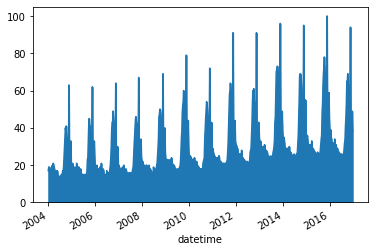

In [34]:
df['apple'].plot.area()

That looks highly seasonal! [Seasonality](https://en.wikipedia.org/wiki/Seasonality) is the presence of regular variations in data. In this case, we expect that the seasonality of apples follows... seasons! It's not easy to see which months are the most red delicious from the graph. Trying to gauge seasonality is a common challenge with time series data. 

The solution is **seasonal plots**. Let's make one by splitting this graph by year, and plotting the yearly trends individually. We'll put the code in a function so we can explore the seasonality of many foods easily:

In [35]:
# new `year` column
df['year'] = df.index.year
# new week column
df['week'] = df.index.isocalendar().week

def plot_seasonal(df, food):
    # pivot the dataframe so years are columns
    pivot_df = df.pivot(index='week', columns='year', values=food)
    # plot one line per year
    pivot_df.plot.line(alpha=0.6, legend=False)

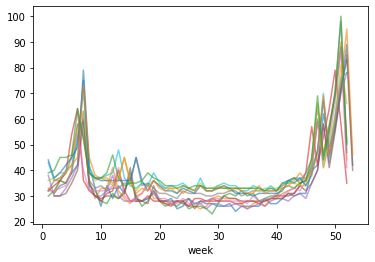

In [36]:
plot_seasonal(df, 'chocolate')

🍫 Chocolate sure is popular around holiday season! Why do you think there is a peak in mid-february? 💝 

Let's explore the trends of a food slightly less fit for special occasions: donuts 🍩

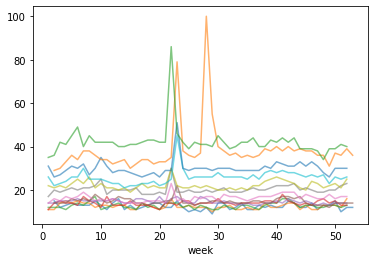

In [37]:
plot_seasonal(df, 'donut')

As expected, donuts are less festive than chocolate. I wonder what caused those peaks! Feel free to explore the data yourself 🤠

Those differences in trends are interesting, but we'd like to compare them more closely. We have a suspicion that some alcoholic drinks have very different seasonal profiles... For example, `champagne` is usually popping around New Year's Eve, whilst `mojito` is a classic summer cocktail.

**Average seasonal plots** allow us to compare the seasonality of two variables. Let's group the values by week, and plot the average values. The result is a graph of the average popularity of the drinks for each week. e.g the values of `champagne` at `week=20` is simply the mean of all the `champagne` values in df happening on the 20th week of the year.

<AxesSubplot:xlabel='week'>

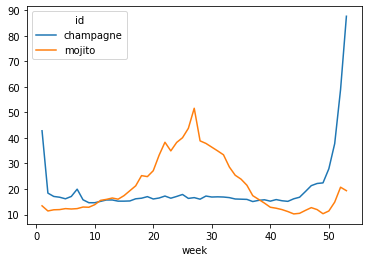

In [38]:
df.groupby('week').mean().plot.line(y=['champagne', 'mojito'])

🍾 Our instincts are confirmed: the New Year is a better time for bubbles than for rum!

Sometimes, we wish to track the cumulative trends of some variables as well as their relative trends. For example, we might be interested in learning the popularity of _beverages_, as well as the breakdown into `tea`, `coffee`, and a hip newcomer `cold-brew-coffee`. 

**Area charts** allow to stack lines and observe the cumulative result. We're interesting in long term trends, so we'll use the yearly averages to remove some of the distracting seasonal variations we observed earlier.

In [41]:
df.groupby(df.index.year).mean().head()

id,anise,apple,apple-au,apple-cider,apple-pie,apricot,asparagus,asparagus-de,asparagus-jp,avocado,...,tom-collins,turkey,turmeric,turnip,watermelon,whiskey-sour,white-russian,white-wine,year,week
datetime,,,,,,,,,,,,,,,,,,,,,
2004,21.326923,21.423077,29.000000,8.673077,6.403846,39.019231,13.653846,6.173077,11.961538,13.269231,...,24.884615,2.769231,10.192308,15.346154,9.057692,16.307692,23.326923,24.250000,2004,27.5
2005,20.326923,21.961538,31.442308,9.596154,6.538462,34.230769,16.076923,6.750000,12.115385,14.423077,...,33.038462,2.903846,9.865385,15.269231,9.788462,15.980769,26.807692,25.923077,2005,26.5
2006,18.442308,22.788462,31.980769,9.730769,7.096154,33.884615,17.423077,5.942308,12.961538,16.500000,...,31.788462,3.038462,9.923077,16.019231,10.384615,18.346154,26.826923,28.846154,2006,26.5
2007,18.000000,23.423077,32.288462,10.173077,6.980769,37.673077,19.250000,5.750000,13.153846,17.961538,...,28.442308,3.250000,12.288462,16.980769,11.038462,18.557692,25.423077,32.115385,2007,26.5
2008,17.461538,25.326923,35.576923,10.865385,7.942308,39.153846,20.865385,6.038462,12.230769,20.192308,...,29.865385,3.519231,15.615385,19.711538,13.384615,18.538462,25.673077,33.942308,2008,26.5


<AxesSubplot:xlabel='datetime'>

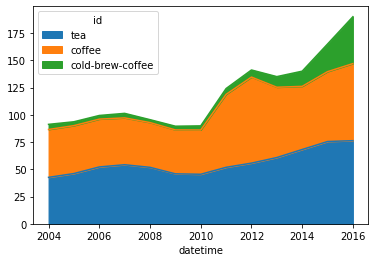

In [42]:
df.groupby(df.index.year).mean()[['tea', 'coffee', 'cold-brew-coffee']].plot.area()

Three are three key insights from this graph:
- beverages are on the rise since 2004
- coffee got a boost around 2010
- cold brews really took off around 2014

ℹ️ This high "density" of information is key in effective data visualization, as explained in the legendary book [The Visual Display of Quantitative Information](https://www.goodreads.com/book/show/17744.The_Visual_Display_of_Quantitative_Information). More on this in lecture 1.6!

💪 Create an area plot of the popularity of `ice-cream` from January to July 2006.

In [ ]:
# INSERT YOUR CODE HERE

🧠 Notice how the seasonality of your graph isn't obvious because of the chosen time window. Can you think of ways to avoid missing this detail in a time series analysis?

## 4. Shifting

The broccoli search expert at Google made a calendar mistake... All his data is late by 8 weeks! We don't want to manually calculate a new column and reindex our `DataFrame`. We _certainly_ don't want to manually update the values. Instead, we can use the [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method:

<AxesSubplot:xlabel='datetime'>

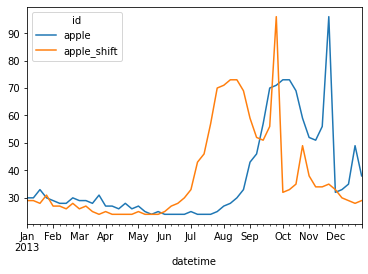

In [43]:
# shift values by 8 weeks and save in new column
df['apple_shift'] = df.shift(periods=-8*7, freq='D')['apple']
# plot old and shifted data
df.loc['2013', ['apple', 'apple_shift']].plot.line()

Phew, broccoli tragedy averted. 🥦 Sometimes we want to shift the _index_ , not the values. We can then use the `axis=0` argument:

<AxesSubplot:xlabel='datetime'>

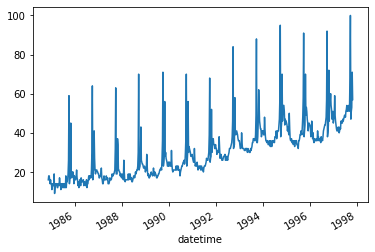

In [44]:
df.shift(-1000, freq='W', axis=0)['broccoli'].plot.line()

That's some old cabbage! More details in the [python data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html#Time-shifts).

## 5. Windowing

🦐 We hear word that shrimps were highly fashionable around 2010, so we'd like to pinpoint this "shrimp chic" theory. 

<AxesSubplot:xlabel='datetime'>

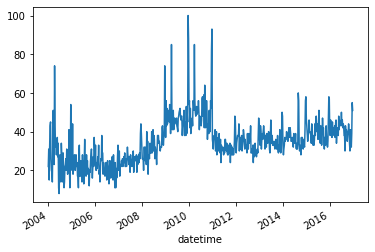

In [45]:
df['shrimp'].plot.line()

There's a definite shellfish bump around 2009, but the [variance](https://en.wikipedia.org/wiki/Variance) of the popularity is muddling the graph. We could "smooth out" the line by plotting its moving average. These [rolling statistics](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html#Rolling-windows) can be calculated with pandas' [`.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html#pandas.Series.rolling) method. The api interface is similar to [`.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) (from lecture 1.3). The method returns a `Rolling` object, on which we must apply an _aggregation function_. In our case, we want a rolling _average_ , so we'll use the [`.mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.window.rolling.Rolling.mean.html) method:

<AxesSubplot:xlabel='datetime'>

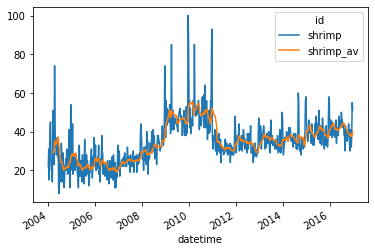

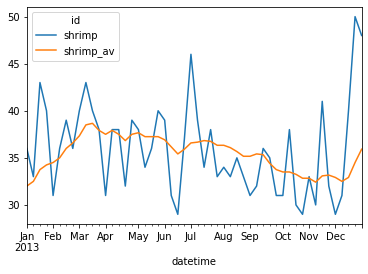

In [46]:
# calculate rolling average of window size 12
df['shrimp_av'] = df['shrimp'].rolling(12).mean()
# plot at two different scales
df.loc[:, ['shrimp', 'shrimp_av']].plot.line()
df.loc['2013', ['shrimp', 'shrimp_av']].plot.line()

📈 Each point of `shrimp_av` is the average popularity of the 12 previous weeks, and allows us to focus on longer term trends. 

💪 Create a line graph of the rolling standard deviation of the popularity of `coconut` 🥥 with a window size of 10, for the year 2012.

<AxesSubplot:xlabel='datetime'>

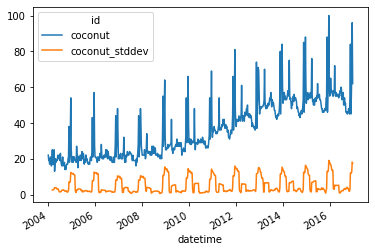

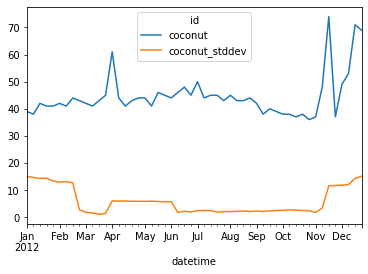

In [47]:
df['coconut_stddev'] = df['coconut'].rolling(10).std()
df.loc[:, ['coconut', 'coconut_stddev']].plot.line()
df.loc['2012', ['coconut', 'coconut_stddev']].plot.line()

🧠 Can you explain what these peaks and troughs represent?

## 6. Resampling

It is common to encounter datasets with irregular time indices, e.g a `DatetimeIndex` where the `Timestamp`s are not regularly spaced. This can be hard to work with for certain downstream tasks, such as times series prediction. One solution is to _resample_ the data to a regular interval. All the old values found in a new interval need to be combined using an _aggregation function_. In this sense, resampling is similar to [windowing](#5.-Windowing), except the aggregation is done on fixed frequency intervals instead of a sliding window. 

In pandas, resampling is done with [`.resample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html). For example, we can resample our google trends to a monthly frequency:


In [48]:
df.resample('M').mean().head()

id,anise,apple,apple-au,apple-cider,apple-pie,apricot,asparagus,asparagus-de,asparagus-jp,avocado,...,turnip,watermelon,whiskey-sour,white-russian,white-wine,year,week,apple_shift,shrimp_av,coconut_stddev
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-31,19.25,18.00,20.50,4.25,3.50,32.00,9.25,1.00,7.50,13.50,...,20.0,3.50,14.5,22.75,26.25,2004,3.5,18.50,NaN,NaN
2004-02-29,20.00,16.25,20.25,2.25,3.25,29.75,13.25,1.25,8.50,13.00,...,15.5,4.50,17.5,18.00,20.75,2004,7.5,17.75,NaN,NaN
2004-03-31,14.60,18.60,41.00,2.80,3.00,24.60,16.60,3.40,11.40,13.00,...,12.8,7.00,19.4,23.60,20.80,2004,12.0,15.80,29.708333,2.625114
2004-04-30,12.75,17.25,36.50,3.00,2.75,28.50,26.75,23.50,17.75,13.75,...,12.5,6.75,16.5,20.00,23.50,2004,16.5,14.25,33.333333,3.688643
2004-05-31,16.20,15.40,39.20,3.20,2.60,29.00,21.00,29.40,21.00,14.60,...,10.6,12.00,14.2,17.60,23.00,2004,21.0,13.80,34.933333,3.370702


The time index now steps in months, and not in weeks. All the values in this new `DataFrame` were _averaged_. More information on resampling and converting frequencies in the [python data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html#Resampling-and-converting-frequencies).

## 7. Interpolation


In [49]:
def forget_data(df, food):
    np.random.seed(1337)
    missing_indices = np.random.randint(low=0, high=len(df), size=42)
    df.iloc[missing_indices, df.columns.get_loc(food)] = None
    
forget_data(df, 'long-island-iced-tea')

Oh no, someone had too many `long-island-iced-tea`s 🍹, and forgot some of the data...

<AxesSubplot:xlabel='datetime'>

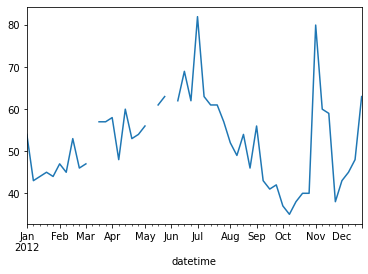

In [50]:
df.loc['2012', 'long-island-iced-tea'].plot.line()

Our beautiful graph! 😭 How do we repair such a mess? Instead of throwing away everything because of a few forgotten values, we can try to _interpolate_ the missing data. [Interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) is "guessing" what the missing values are, based on their neighbours. Linear interpolation is the most common kind.

💄 Let's make our graph pretty again with the [`.interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) method:

<AxesSubplot:xlabel='datetime'>

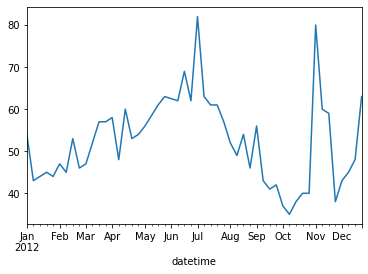

In [51]:
df['long-island-iced-tea'] = df['long-island-iced-tea'].interpolate()
df.loc['2012', 'long-island-iced-tea'].plot.line()

Data repaired, hangover prevented. ⛑ Please note that the values are _not_ the same as before and there is no way to magically recover lost data. However, interpolation can enable a larger scale analysis that would otherwise fail, or act as a "better than nothing" solution. There are many interpolation methods, check out the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) for more details!

## 8. Summary

Today, we went on a tour of pandas' [time series & date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-series-date-functionality). We learned about the **`Timestamp`**, **`Timedelta`**, and **`Period`** classes, and their associated time index classes. Then, we selected and manipulated a `DataFrame` using **time-based indexing**. We loaded a Google trends [dataset](https://www.kaggle.com/GoogleNewsLab/food-searches-on-google-since-2004) of popular food search terms, and **pivoted** the table to access our ordered time index. We explored the data, and visualized some of its time-specific aspects, such as **seasonality** and **comparative trends**. We also learned time data cleaning transformations, such as **index shifting**, **rolling statistics**, **resampling**, and **interpolation**. Overall, we discovered the main techniques for time series data exploration, tested them on a real dataset, and got insights into some dietary trends.

# Resources
## Core Resources

- [Kaggle dataset of popular food searches](https://www.kaggle.com/GoogleNewsLab/food-searches-on-google-since-2004)
- [Pandas time series & date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- [Python Data Science Handbook - Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)

## Additional Resources

- [Time formatting](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)
- [Exploring and visualizing time series](https://uc-r.github.io/ts_exploration)
- [Times series analysis with pandas](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)
- [Times series visualization with python](https://machinelearningmastery.com/time-series-data-visualization-with-python/)
- [7 types of temporal visualizations](https://humansofdata.atlan.com/2016/11/visualizing-time-series-data/)
- [11 stunning time series graphs](https://medium.com/@plotlygraphs/time-series-graphs-eleven-stunning-ways-you-can-use-them-cd1c1bcfe749)
- [Reshaping and pivot tables](https://pandas.pydata.org/docs/user_guide/reshaping.html)
- [Analysing time series data in pandas](https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621)
